In [655]:
import pandas as pd
import numpy as np
import spacy
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from gensim import corpora, models, matutils
import logging
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
%matplotlib inline

# Text analysis
## Parsing with SpaCy

In [93]:
df = pd.read_pickle('data/df_processed')

In [94]:
df = df.reset_index().rename({'index':'post_number'}, axis=1)

# rename Chinese language code to zh to make it compatible with spacy
df.loc[df.language.str.startswith('z'), 'language'] = 'zh' 

Most sentences are between 10-20 tokens. Similar to tweets.

In [3]:
nlp = spacy.load('en_core_web_sm')

In this notebook, we will parse through the text using SpaCy so we can compile a list of adjectives used to describe various key words like world leaders. These lists will let us see how users are referring to these terms and may provide some insight into how users feel about them.

Before we do that though, we need to know what language models we need to download.

In [19]:
language_codes = pd.read_html('http://www.lingoes.net/en/translator/langcode.htm')

In [22]:
language_codes = language_codes[0]

In [28]:
language_codes.set_index(0, inplace=True)

In [34]:
# Loop through languages in the df
for code in df.language.unique():
    try:
        print(language_codes.loc[code])
    except Exception as e: print(e)

1    English
Name: en, dtype: object
1    Afrikaans
Name: af, dtype: object
1    Indonesian
Name: id, dtype: object
1    Estonian
Name: et, dtype: object
'no'
'so'
1    German
Name: de, dtype: object
1    Finnish
Name: fi, dtype: object
1    Swahili
Name: sw, dtype: object
1    Italian
Name: it, dtype: object
1    Spanish
Name: es, dtype: object
1    Dutch
Name: nl, dtype: object
1    Danish
Name: da, dtype: object
1    Tagalog
Name: tl, dtype: object
1    Romanian
Name: ro, dtype: object
1    Hindi
Name: hi, dtype: object
1    Slovenian
Name: sl, dtype: object
1    French
Name: fr, dtype: object
'unknown'
1    Lithuanian
Name: lt, dtype: object
1    Croatian
Name: hr, dtype: object
1    Gujarati
Name: gu, dtype: object
1    Slovak
Name: sk, dtype: object
1    Albanian
Name: sq, dtype: object
1    Ukrainian
Name: uk, dtype: object
1    Swedish
Name: sv, dtype: object
1    Marathi
Name: mr, dtype: object
1    Turkish
Name: tr, dtype: object
1    Catalan
Name: ca, dtype: object
1    Urdu

Download and install each language in the df that SpaCy is compatible with.

In [53]:
installed_languages = 'en, ca, da, nl, fr, de, it, lt, zh, ja'.split(', ')
installed_languages

['en', 'ca', 'da', 'nl', 'fr', 'de', 'it', 'lt', 'zh', 'ja']

In [95]:
# pare down the df to just languages that are compatible with spacy
df_processed = df[df.language.isin(installed_languages)].copy()

In [80]:
df_processed[df_processed.language == 'nl'].index

Int64Index([  4565,   4566,   4567,   4568,   4569,  13694,  46687,  46688,
             46689,  55966,
            ...
            873293, 877537, 883533, 894969, 894970, 924182, 924183, 935672,
            935673, 936390],
           dtype='int64', length=158)

In [102]:
%%time

df_parsed = pd.DataFrame(columns=list(df_processed.columns) + ['spacy_doc'])

for language in installed_languages:
    try:
        nlp = spacy.load(language + '_core_web_sm')
    except:
        nlp = spacy.load(language + '_core_news_sm')
    sub_df = df_processed[df_processed.language == language].copy()
    sub_df['spacy_doc'] = list(nlp.pipe(sub_df.text))
    sub_df.to_pickle(f'data/spacy_{language}')

CPU times: user 33min 52s, sys: 1min 13s, total: 35min 6s
Wall time: 38min 41s


In [103]:
%%time

for language in installed_languages:
    sub_df = pd.read_pickle(f'data/spacy_{language}')
    df_parsed = pd.concat([df_parsed, sub_df])

CPU times: user 5min 13s, sys: 50 s, total: 6min 3s
Wall time: 8min 3s


In [105]:
df_parsed.to_pickle('data/df_parsed')

## Adjective modifier analysis
The data is now ready for text analysis. We will first write a function that generates a list of the 10 most common adjectives used to describe various world leaders and compare for each subreddit. We will start first with English and move on to other languages.

In [340]:
terms = 'putin, zelensky, biden, zelenskyy, invasion, ukraine, russia, country, president'.split(', ')

In [341]:
def adj_analysis(term, country, language='en', number=10, df=df_parsed):
    term = term.lower()
    df = df.loc[(df.country == country.lower()) & (df.language == language.lower())].copy()
    adj_modifiers = []
    top_adj_mod = []
    
    # code taken from Metis spacy lesson
    for row in df.spacy_doc:
        for token in row:
            if token.text == term.lower():
                for child in token.children:
                    if child.dep_ == 'amod':
                        adj_modifiers += [child.text.lower()]
#     return adj_modifiers
    return Counter(adj_modifiers).most_common()[:number]    

Loop through some terms and countries to see what countries are saying about these topics. Choose thte countries with the most data available.

In [342]:
df_parsed.groupby('country')['country'].count().sort_values(ascending=False).iloc[:10]

country
ukraine          478100
canada            63016
unitedkingdom     47280
india             47148
italy             42327
france            36114
china             29316
poland            25845
southafrica       16302
newzealand        15620
Name: country, dtype: int64

In [343]:
countries = list(df_parsed.groupby('country')['country'].count().sort_values(ascending=False).iloc[:8].index) + ['russia', 'saudiarabia']

In [344]:
results = []
for term in terms:
    temp = []
    for country in countries:
        temp += [adj_analysis(term, country)]
    results += [temp]

In [345]:
with pd.option_context('display.max_rows', None,'display.max_columns', None,
    'display.precision', 3,
                       ):
    display(pd.DataFrame(np.array(results, dtype='object'), columns = countries, index=terms))

,ukraine,canada,unitedkingdom,india,italy,france,china,poland,russia,saudiarabia
putin,"[(pro, 21), (little, 8), (good, 6), (fucking, ...","[(fine, 2), (pro, 2), (temporary, 1), (previou...","[(pro, 5), (anti, 2), (complimented, 2), (same...","[(western, 1), (eg:-, 1), (wide, 1), (anti, 1)...",[],[],"[(mad, 2), (pro, 2), (poor, 1), (better, 1)]","[(lovely, 1), (safe, 1), (-, 1), (russian, 1),...",[],[]
zelensky,"[(brilliant, 1), (much, 1)]","[(anti, 1), (fair, 1)]","[(great, 1)]",[],[],[],[],[],[],[]
biden,"[(anti, 1), (ugly, 1), (old, 1), (unlikely, 1)]","[(form, 1)]","[(deranged, 1)]",[],[],[],[],[],[],[]
zelenskyy,[],[],[],[],[],[],[],[],[],[]
invasion,"[(russian, 928), (illegal, 47), (ongoing, 47),...","[(russian, 197), (illegal, 18), (military, 15)...","[(russian, 152), (illegal, 24), (full, 12), (m...","[(russian, 122), (provoked, 14), (chinese, 12)...","[(russian, 4), (first, 2), (non, 2), (full, 1)...","[(russian, 8), (full, 1), (subsequent, 1), (uk...","[(russian, 110), (military, 19), (chinese, 16)...","[(russian, 58), (military, 5), (german, 3), (s...","[(russian, 2), (fucking, 1)]","[(russian, 3), (stupid, 1), (ukrainian, 1), (r..."
ukraine,"[(pro, 15), (live, 6), (western, 6), (/r, 5), ...","[(pro, 1), (supporting, 1), (new, 1), (russian...","[(fuck, 3), (invading, 2), (able, 2), (anti, 1...","[(pro, 2), (loving, 2), (western, 2), (left, 1...",[],[],"[(eastern, 3), (pro, 2), (fascist, 1), (naked,...","[(central, 1), (strong, 1), (problematic, 1), ...",[],[]
russia,"[(soviet, 15), (pro, 9), (eastern, 6), (wester...","[(pro, 2), (nuclear, 1), (anti, 1), (western, ...","[(bad, 6), (pro, 2), (sino, 1), (hardline, 1),...","[(pro, 2), (poor, 2), (average, 1), (isolated,...","[(fullest, 1)]",[],"[(pro, 2), (ukraine, 2), (stable, 1), (right, ...","[(whole, 3), (free, 2), (entire, 1), (ukraine,...","[(live, 1)]",[]
country,"[(own, 270), (other, 231), (entire, 162), (who...","[(other, 76), (own, 47), (entire, 37), (non, 2...","[(other, 46), (european, 43), (only, 27), (own...","[(other, 64), (sovereign, 52), (democratic, 43...","[(whole, 1), (second, 1), (most, 1), (dependen...","[(democratic, 2), (single, 1), (powerful, 1), ...","[(other, 25), (sovereign, 21), (own, 19), (ind...","[(other, 29), (safe, 20), (own, 17), (first, 1...","[(other, 3), (only, 3), (european, 3), (sovere...","[(other, 5), (sovereign, 3), (western, 3), (in..."
president,"[(ukrainian, 87), (russian, 58), (former, 46),...","[(former, 10), (ukrainian, 6), (current, 3), (...","[(russian, 17), (ukrainian, 13), (-, 5), (form...","[(ukrainian, 19), (pro, 18), (russian, 17), (-...","[(russian, 2)]","[(french, 2), (belarusian, 1), (ukrainian, 1),...","[(ukrainian, 13), (russian, 7), (current, 6), ...","[(polish, 4), (nazi, 3), (russian, 3), (jewish...","[(ukraine, 1), (elected, 1)]","[(tired, 1)]"


This table isn't very illuminating. Most terms have few modifying adjectives, even for 800,000 English posts. More common words like "invasion" or "country" have more modifying adjectives but there are no clear patterns to draw from.

## Topic analysis
### EDA for sentence length
Before topic modeling, let's get a sense of the distribution of sentence lengths? That is, how many words do sentences have in this data set. This will help us determine if sentiment analyzers meant for Twitter that are more appropriate for short strings could work here.

In [179]:
sent_lengths = df_parsed.spacy_doc.apply(lambda x: len(x))

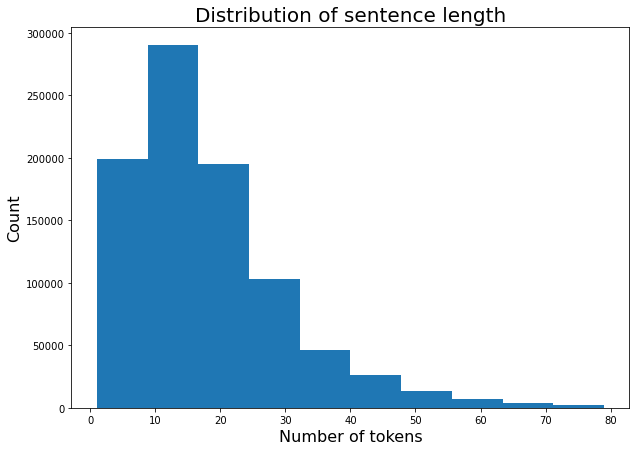

In [195]:
sent_lengths[sent_lengths < 80].plot(kind='hist', figsize=(10,7));
plt.xlabel('Number of tokens', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.title('Distribution of sentence length', fontsize=20);

Most sentences are between 10-20 tokens (words) so Twitter sentiment analyzers are probably a valid option for later.

### Cleaning prior to topic analysis
Let's get lemmatize and rid of numbers, punctuation, and stop words.

In [366]:
def clean(sentence): # take in spacy token, return lemmas and remove numbers, punctuation, and stop words
    return ' '.join([token.lemma_ for token in sentence if token.pos_ != 'NUM' and token.pos_ != 'PUNCT' and not token.is_stop])

In [367]:
df_parsed['spacy_doc_cleaned'] = df_parsed.spacy_doc.apply(clean)

## Topic extraction
For simplicity, let's limit analysis to only posts in English.

In [368]:
df_topics = df_parsed.loc[df.language=='en', 'spacy_doc_cleaned'].copy()

In [369]:
cv = CountVectorizer()
dtm = cv.fit_transform(df_topics)

In [370]:
print(f'There are {dtm.shape[0]} posts and {dtm.shape[1]} unique words')

There are 814087 posts and 55810 unique words


In [371]:
model = TruncatedSVD
vectorizer = CountVectorizer()
language = 'en'

df_topics = df_parsed.loc[df_parsed.language == language, 'spacy_doc_cleaned']

dtm = vectorizer.fit_transform(df_topics)
model = model(num_topics)
model.fit(dtm)
variance = model.explained_variance_ratio_[0].round(3)
print(f'Explained variance: {variance}')
topic_term = model.components_.round(3)
topic_term_df = pd.DataFrame(topic_term.round(3),
            index = ['Topic '+ str(num) for num in range(num_topics)],
            columns = vectorizer.get_feature_names_out())
for i in range(num_topics):
    print(topic_term_df.iloc[i].sort_values(ascending=False).iloc[:10])

Explained variance: 0.032
ukraine      0.668
russia       0.545
russian      0.202
war          0.119
statement    0.115
ukrainian    0.109
putin        0.098
suspend      0.098
people       0.086
nato         0.081
Name: Topic 0, dtype: float64
russia       0.707
suspend      0.200
operation    0.101
russian      0.088
shipment     0.053
china        0.041
country      0.029
putin        0.025
sale         0.025
war          0.024
Name: Topic 1, dtype: float64
russia         0.312
statement      0.180
suspend        0.131
national       0.085
sport          0.068
von            0.060
ist            0.060
bell           0.060
euvsdisinfo    0.060
yurop          0.060
Name: Topic 2, dtype: float64


Many terms seem similar so we will try and differentiate each topic by the terms that are unique. These topics only capture about 3% of the discussion though but they are the most common ones.

### Reddit topics across all English posts
1. Putin and Russia's relationship with NATO
2. The sale and movement of military equipment
3. The amount of reliable information available on the conflict and maybe something to do with the Paralympics which banned Russian and Belarussian athletes

For each post, what is the number 1 topic?

In [381]:
doc_topic = model.transform(dtm)

In [385]:
doc_topic_df = pd.DataFrame(doc_topic.round(5), index = df_topics, 
                            columns = ['Topic ' + str(x) for x in range(num_topics)])
doc_topic_df

,Topic 0,Topic 1,Topic 2
spacy_doc_cleaned,,,
& gt indian student walk Kharkiv bombing continue part city,0.08019,0.01944,-0.10755
& gt ukrainian army escort student short distance Pesochin point bunker provide protect student bombing,0.20838,-0.09686,-0.09141
Kremlin breakout Modi Putin telephone,0.10354,0.02795,-0.40308
claim Ukrainians student hostage,0.02801,0.00309,-0.04084
Russia NGA body get vote regardless subject resolution,0.57687,0.71313,0.27548
...,...,...,...
source [,0.04553,-0.05814,0.05520
AE stance Ukraine war reflect strong alliance Russia,1.34594,0.20418,0.09351
inside ukrainian pavilion Expo Gulf emirate Dubai tourist read note place board guest support Ukraine,0.88096,-0.65192,0.03001


Considering that the number of topics is likely very large, it does not make sense to analyze individual posts by topic.


Let's try separating topics by country, selecting only countries that will likely have the greatest relevance to the conflict.
* Russia
* Belarus
* Ukraine
* Poland

In [372]:
def get_topics(country, vectorizer, model, df = df_parsed, language = 'en', num_topics=3):
    df_topics = df.loc[(df.country == country) & (df.language == language), 'spacy_doc_cleaned']
#     display(df_topics)
    dtm = vectorizer.fit_transform(df_topics)
    model = model(num_topics)
    model.fit(dtm)
    variance = model.explained_variance_ratio_[0].round(3)
    print(f'Explained variance: {variance}')
    topic_term = model.components_.round(3)
    topic_term_df = pd.DataFrame(topic_term.round(3),
                index = ['Topic '+ str(num) for num in range(num_topics)],
                columns = vectorizer.get_feature_names_out())
    for i in range(num_topics):
        print(topic_term_df.iloc[i].sort_values(ascending=False).iloc[:10], '\n')

In [373]:
topic_countries = 'Russia, Belarus, Ukraine, Poland'.lower().split(', ')

In [389]:
for country in topic_countries:
    print(country.capitalize())
    get_topics(country, CountVectorizer(ngram_range=(1,2)), TruncatedSVD)

Russia
Explained variance: 0.083
reddit          0.295
link            0.268
ns              0.262
place           0.201
use             0.201
np place        0.200
replace ww      0.200
place www       0.200
form replace    0.200
replace         0.200
Name: Topic 0, dtype: float64 

russia              0.321
to                  0.238
concern             0.237
subreddit           0.237
message             0.237
to russia           0.237
contact             0.237
question            0.237
moderator           0.236
question concern    0.236
Name: Topic 1, dtype: float64 

account                  0.474
help                     0.239
protect                  0.238
help protect             0.237
administrative reddit    0.237
administrative           0.237
user                     0.237
user administrative      0.237
account account          0.237
account user             0.237
Name: Topic 2, dtype: float64 

Belarus
Explained variance: 0.016
ukraine       0.653
russia        0.344
belarus

To define topics, we need to do this manually for each topic and country combination.

|         | Explained variance | Topic 0                                 | Topic 1                                            | Topic 2                                |   |   |   |   |   |
|---------|--------------------|-----------------------------------------|----------------------------------------------------|----------------------------------------|---|---|---|---|---|
| Russia  | 8.30%              | Reddit issues                           | Reddit moderator                                   | Administrative Reddit issues           |   |   |   |   |   |
| Belarus | 1.60%              | Support for Putin and Russia in Belarus | What the Russian or Belarusian leadership thinks | Killing Lukashenko                     |   |   |   |   |   |
| Ukraine | 3.50%              | National defense of Ukraine             | Suspending shipments related to Russia             | Suspending shipments related to Russia |   |   |   |   |   |
| Poland  | 1.40%              | Help for NATO                           | Attacks involving NATO                             | Helping refugees at the border         |   |   |   |   |   |

Looking at the above table, it seems like it is not feasible to generalize from topics extracted from country subreddits to what the population living in that country is discussing. It is unlikely Belarusian authorities would  permit a subreddit to contain information on killing their country's president. Likely, English speakers are largely pro-Ukrain and constitute the majority of posters in any Eastern country's subreddit, skewing the results towards pro-Ukraine.

### Tfidf
Let's try Tfidf instead of the CountVectorizer.

In [398]:
for country in topic_countries:
    print(country.capitalize())
    get_topics(country, TfidfVectorizer(ngram_range=(1,2)), TruncatedSVD)

Russia
Explained variance: 0.047
ns                   0.358
link                 0.323
reddit               0.300
url ns               0.245
link url             0.245
reddit link          0.245
url                  0.245
non participation    0.128
participation        0.128
stand non            0.128
Name: Topic 0, dtype: float64 

moderator subreddit    0.247
contact moderator      0.247
russia question        0.247
subreddit message      0.247
to russia              0.247
message compose        0.247
compose to             0.247
compose                0.247
question concern       0.247
moderator              0.246
Name: Topic 1, dtype: float64 

bot action               0.379
action perform           0.379
perform automatically    0.379
automatically            0.378
perform                  0.378
bot                      0.378
action                   0.375
reason hard              0.000
realize deal             0.000
realise                  0.000
Name: Topic 2, dtype: float64 

B

Significantly worse results with Tfidf. Topics are all similar or contain uninterpretable words. We'll stick with CountVectorizer

## Nonnegative matrix factorization
Let's try a different way to find topics

In [378]:
def get_topics_NMF(country, vectorizer, model, df = df_parsed, language = 'en', num_topics=3):
    df_topics = df.loc[(df.country == country) & (df.language == language), 'spacy_doc_cleaned']
#     display(df_topics)
    dtm = vectorizer.fit_transform(df_topics)
    model = model(num_topics, init = "nndsvda")
    model.fit(dtm)
#     variance = model.explained_variance_ratio_[0].round(3)
#     print(f'Explained variance: {variance}')
    topic_term = model.components_.round(3)
    topic_term_df = pd.DataFrame(topic_term.round(3),
                index = ['Topic '+ str(num) for num in range(num_topics)],
                columns = vectorizer.get_feature_names_out())
    for i in range(num_topics):
        print(topic_term_df.iloc[i].sort_values(ascending=False).iloc[:10], '\n')

In [390]:
for country in topic_countries:
    print(country.capitalize())
    get_topics_NMF(country, CountVectorizer(ngram_range=(1,2)), NMF)

Russia
link         2.390
ns           2.335
reddit       2.168
place        1.820
use          1.819
form         1.811
replace      1.810
ww           1.810
ns format    1.809
place www    1.809
Name: Topic 0, dtype: float64 

russia             2.580
to                 1.911
question           1.910
subreddit          1.910
contact            1.909
message            1.908
to russia          1.903
concern            1.903
compose            1.902
message compose    1.902
Name: Topic 1, dtype: float64 

account                  3.761
reddit                   1.982
help                     1.891
protect                  1.885
user                     1.878
account user             1.876
user administrative      1.876
protect account          1.876
administrative reddit    1.876
administrative           1.876
Name: Topic 2, dtype: float64 

Belarus
ukraine       7.117
war           0.849
belarus       0.848
help          0.529
support       0.468
belarusian    0.462
fight         0.419

## Latent Dirichlet Analysis
The last topic analyzer to try is Latent Dirichlet Analysis.

In [395]:
def get_topics_LDA(country, vectorizer, df = df_parsed, language = 'en', num_topics=3, passes=10):
    df_topics = df.loc[(df.country == country) & (df.language == language), 'spacy_doc_cleaned']
#     display(df_topics)
    dtm = vectorizer.fit_transform(df_topics)
    
    term_doc = dtm.transpose()
    corpus = matutils.Sparse2Corpus(term_doc)
    id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())
    lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=passes)
    lda.print_topics()

The LDA results on the large Ukraine subreddit take a very long time to complete and generates an extremely long output so in the interest of brevity, we'll just skip it.

Because the dominant topics in all of the countries are so similar (e.g. Ukraine, Russia), let's try a CorEx model to try and force out some smaller topics.

## Sentiment scores by key word
What if we averaged the sentiment score by keyword? Create a table of terms and what the average sentiment score is for each term. First remove countries with less than 1000 posts overall.

In [417]:
df_parsed_en = df_parsed.loc[df_parsed.language=='en'].copy()

In [422]:
terms

['putin',
 'zelensky',
 'biden',
 'zelenskyy',
 'invasion',
 'ukraine',
 'russia',
 'country',
 'president']

In [418]:
sentiment_scores = pd.read_pickle('data/sentiment_scores')
df_parsed_en['sentiment'] = list(sentiment_scores)

In [486]:
# Limit data set to those countries with at least 1000 posts
df_parsed_en_1000 = df_parsed_en.loc[df_parsed_en.groupby('country')['country'].transform('count') >= 1000]

In [444]:
# Search for capitalized and lowercase terms
# search_terms = [x + '|' + y for x, y in list(zip(terms, np.array(list(map(str.capitalize, terms)))))]
# search_terms
terms

['putin',
 'zelensky',
 'biden',
 'zelenskyy',
 'invasion',
 'ukraine',
 'russia',
 'country',
 'president']

In [532]:
term_sentiment_df = pd.DataFrame(index = df_parsed_en_1000.country.unique())
for term in terms:
    search_term = term + '|' + term.capitalize()
    sub_df = df_parsed_en_1000.loc[df_parsed_en_1000.text.str.contains(search_term)]
    sub_df = pd.DataFrame(pd.DataFrame(sub_df.groupby('country')['sentiment'].mean()))
    sub_df[term + '_count'] = df_parsed_en_1000.loc[df_parsed_en_1000.text.str.contains(search_term)].groupby('country')['country'].count()
    sub_df.rename(columns = {'sentiment': term}, inplace=True)
    term_sentiment_df = pd.concat([term_sentiment_df, sub_df], axis=1)

term_sentiment_df

,putin,putin_count,zelensky,zelensky_count,biden,biden_count,zelenskyy,zelenskyy_count,invasion,invasion_count,ukraine,ukraine_count,russia,russia_count,country,country_count,president,president_count
india,-0.070754,2528,-0.062733,219,-0.000584,183.0,0.019369,45.0,-0.064206,1143,-0.076323,7021,-0.056387,11247,-0.069976,2038,-0.045741,293
pakistan,-0.019693,341,0.063964,42,-0.009809,66.0,0.164160,10.0,-0.097737,254,-0.062604,1224,-0.037199,2042,-0.059660,450,0.083104,80
saudiarabia,-0.080691,68,0.031633,3,-0.337792,26.0,0.340400,2.0,-0.100196,51,-0.091439,265,-0.123305,324,-0.112279,81,-0.372355,11
switzerland,-0.076777,376,0.060431,26,-0.388792,12.0,-0.073000,5.0,-0.078199,136,-0.079870,891,-0.064152,1290,-0.041003,298,-0.084839,41
germany,-0.124489,634,-0.169160,25,-0.121460,25.0,-0.393383,6.0,-0.107134,143,-0.090695,1182,-0.095550,1833,-0.080700,379,-0.042071,35
france,-0.058424,242,-0.033695,56,-0.072571,7.0,0.093463,8.0,-0.051918,66,-0.015762,431,-0.051672,552,0.029411,57,0.016556,66
poland,-0.080809,1596,0.071866,91,-0.086454,68.0,0.049145,20.0,-0.040180,334,0.006494,3982,-0.083668,4726,-0.066725,1014,0.037169,113
polska,-0.059215,150,0.083050,10,0.219650,4.0,0.447900,2.0,-0.160134,32,-0.009248,280,-0.098471,308,-0.003523,39,-0.057117,18
belarus,-0.132386,725,-0.030274,42,-0.006263,16.0,-0.132778,9.0,-0.078605,149,-0.090932,1473,-0.111215,1885,-0.080929,353,-0.045614,92
ukraine,-0.117987,40277,0.019607,4555,-0.071955,1876.0,0.007888,1179.0,-0.074691,7605,0.019599,82448,-0.109786,101802,-0.063385,10996,0.156904,6181


For each term, what are the top five most positive and negative countries?

In [494]:
results = {}
for term in terms:
    results[term] = ['']
    results[term] += [term_sentiment_df[term].sort_values(ascending=False).iloc[:5]]
    results[term] += [term_sentiment_df[term].sort_values(ascending=True).iloc[:5]]
    results[term] = results[term][1:]

In [496]:
results['zelensky']

[algeria        0.427567
 bangladesh     0.142920
 morocco        0.129060
 mexico         0.093200
 southafrica    0.087200
 Name: zelensky, dtype: float64,
 nigeria   -0.223500
 germany   -0.169160
 vietnam   -0.069292
 russia    -0.066351
 india     -0.062733
 Name: zelensky, dtype: float64]

<AxesSubplot:>

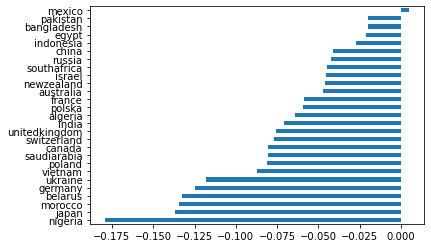

In [498]:
term_sentiment_df.putin.sort_values().plot(kind='barh')

In [510]:
data

,putin,zelensky,biden,zelenskyy,invasion,ukraine,russia
ukraine,-0.117987,0.019607,-0.071955,0.007888,-0.074691,0.019599,-0.109786
russia,-0.042433,-0.066351,-0.727133,0.220200,-0.173370,-0.068214,0.027045


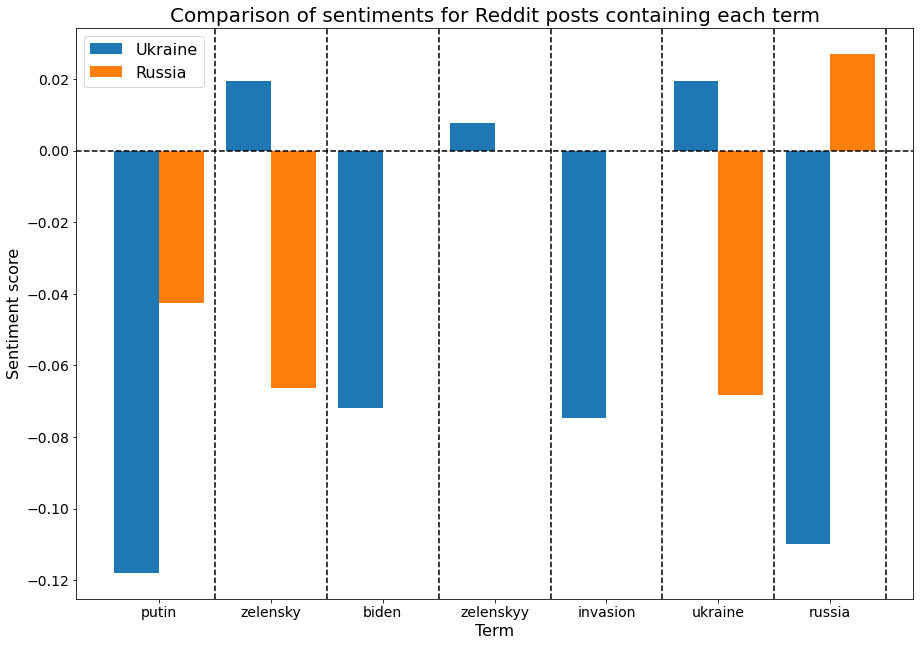

In [634]:
# https://www.geeksforgeeks.org/create-a-grouped-bar-plot-in-matplotlib/

# Filter out data where there are fewer than 20 posts that mention the term
term_sentiment_df_filtered = (term_sentiment_df.iloc[:, ::2]*(term_sentiment_df.iloc[:, 1::2] > 20).astype('int').values).iloc[:,:-2]

x = np.arange(len(term_sentiment_df_filtered.columns))
y1 = term_sentiment_df_filtered.loc['ukraine']
y2 = term_sentiment_df_filtered.loc['russia']
width = 0.40
  
# plot data in grouped manner of bar type
plt.figure(figsize=(15,10.5))
plt.bar(x-0.2, y1, width)
plt.bar(x+0.2, y2, width)
plt.legend(["Ukraine", 'Russia'], fontsize=16)
for i in np.arange(0.5, len(data.columns), 1):
    plt.axvline(x=i, color='black', linestyle = '--')
plt.axhline(y=0, color = 'black', linestyle='--')
plt.xticks(x, term_sentiment_df_filtered.columns, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Term", fontsize=16)
plt.ylabel("Sentiment score", fontsize=16)
plt.title('Comparison of sentiments for Reddit posts containing each term', fontsize=20)
plt.show()

Is there a relationship between how authoritarian a country is and how it views an authoritarian leader such as Putin?

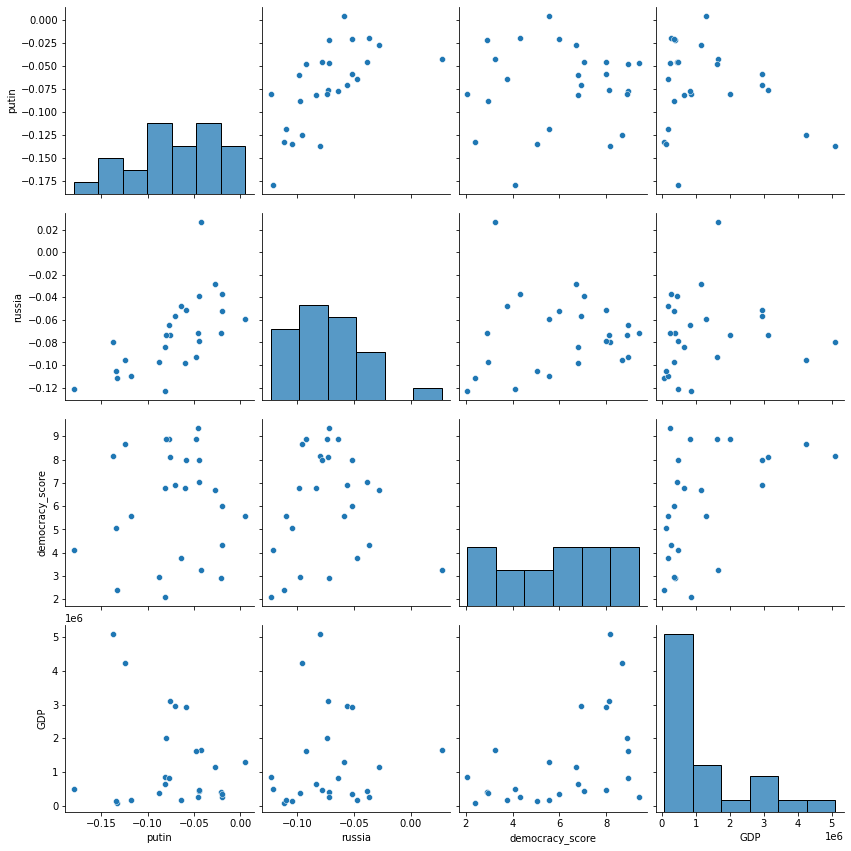

In [654]:
# Drop China because the GDP is an outlier
sns.pairplot(data=term_sentiment_df_filtered[['putin', 'russia']].join(df_parsed.groupby('country')[['democracy_score', 'GDP']]
                                                     .mean(), how = 'left').drop('china'), height=3);

There doesn't seem to be any correlation between democracy_score and GDP with a subreddit's sentiment towards Putin or Russia.

## CorEx topic modeling
The last topic modeler we'll try is CorEx because the topic models above seem dominated by Russia and Ukraine. Can we pull out topics relating to Putin, Zelensky, or Biden?

In [658]:
df_parsed_en.head()

,post_number,country,comments_or_subs,democracy_score,GDP,abstained,text,language,provided_aid,spacy_doc,spacy_doc_cleaned,sentiment
0,0,india,comments,6.91,2946061.0,True,"&gt; Indian students walk out of Kharkiv, as b...",en,True,"(&, gt, ;, Indian, students, walk, out, of, Kh...",& gt indian student walk Kharkiv bombing conti...,0.0000
1,0,india,comments,6.91,2946061.0,True,&gt; Ukrainian army escorted around - students...,en,True,"(&, gt, ;, Ukrainian, army, escorted, around, ...",& gt ukrainian army escort student short dista...,0.3818
2,1,india,comments,6.91,2946061.0,True,The Kremlin breakout of the Modi-Putin telepho...,en,True,"(The, Kremlin, breakout, of, the, Modi, -, Put...",Kremlin breakout Modi Putin telephone,0.0000
3,1,india,comments,6.91,2946061.0,True,The are claiming Ukrainians are using the stud...,en,True,"(The, are, claiming, Ukrainians, are, using, t...",claim Ukrainians student hostage,0.0000
4,2,india,comments,6.91,2946061.0,True,"Russia is part of the NGA, everyone in the bod...",en,True,"(Russia, is, part, of, the, NGA, ,, everyone, ...",Russia NGA body get vote regardless subject re...,0.0000


In [659]:
# Code taken from Metis lesson on CorEx

vectorizer = CountVectorizer(max_features=2500,
                             stop_words='english', 
                             token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(df_parsed_en.spacy_doc_cleaned)
words = list(np.asarray(vectorizer.get_feature_names_out()))

In [660]:
topic_model = ct.Corex(n_hidden= 3 , ### YOUR NUMBER OF TOPICS HERE
                       words= words  ,   ### YOUR VOCABULARY HERE
                       seed=1
                       )

topic_model.fit(  doc_word  ,       ### YOUR DOCUMENT TERM MATRIX HERE
                words= words   , ### YOUR VOCABULARY HERE
                docs= df_parsed_en.spacy_doc_cleaned      ### YOUR DOCUMENT SERIES HERE
                )

In [661]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print(f'{n}: {", ".join(topic_words)}')

0: bot, compose, moderator, perform, automatically, contact, identification, sar, message, concern
1: russian, people, medium, government, like, war, military, say, en, state
2: russia, nato, nuclear, country, weapon, ukraine, border, oil, supply, china


In [665]:
def corex(country, data=df_parsed_en, num_topics=3):
    country = country.lower()
    
    vectorizer = CountVectorizer(max_features=2500,
                             stop_words='english', 
                             token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)
    
    data = data.loc[data.country==country].spacy_doc_cleaned.copy()

    doc_word = vectorizer.fit_transform(data)
    words = list(np.asarray(vectorizer.get_feature_names_out()))
    
    topic_model = ct.Corex(n_hidden= num_topics , ### YOUR NUMBER OF TOPICS HERE
                       words= words  ,   ### YOUR VOCABULARY HERE
                       seed=1
                       )

    topic_model.fit(  doc_word  ,       ### YOUR DOCUMENT TERM MATRIX HERE
                    words= words   , ### YOUR VOCABULARY HERE
                    docs= data      ### YOUR DOCUMENT SERIES HERE
                    )
    
    topics = topic_model.get_topics()
    for n,topic in enumerate(topics):
        topic_words,_,_ = zip(*topic)
        print(f'{n}: {", ".join(topic_words)}')

In [664]:
corex('Ukraine')

0: compose, contact, moderator, message, perform, automatically, concern, subreddit, question, action
1: russian, russia, force, movement, war, location, identification, sar, en, military
2: ukraine, president, ukrainian, official, humanitarian, foreign, border, say, support, fly


In [666]:
corex('Russia')

0: ns, link, reddit, www, guideline, format, participation, submission, np, replace
1: russia, question, message, contact, subreddit, concern, moderator, compose, russian, ukraine
2: perform, automatically, bot, action, angels, alley, attach, quote, ff, wikipedia


In [722]:
def corex_anchors(country, anchors, anchor_strength=5, data=df_parsed_en, num_topics=3):
    '''anchors take the form [[anchor1, anchor2, etc.], [anchor3], [anchor4]] if there are 3 topics'''
    country = country.lower()
    
    vectorizer = CountVectorizer(max_features=2500,
                             stop_words='english', 
                             token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)
    
    data = data.loc[data.country==country].spacy_doc_cleaned.copy()

    doc_word = vectorizer.fit_transform(data)
    words = list(np.asarray(vectorizer.get_feature_names_out()))
    
    topic_model = ct.Corex(n_hidden= num_topics, ### YOUR NUMBER OF TOPICS HERE
                       words= words,  ### YOUR VOCABULARY HERE
                       seed=1
                       )

    topic_model.fit( doc_word ,          ### YOUR DOCUMENT TERM MATRIX HERE
                    words= words ,      ### YOUR VOCABULARY HERE
                    docs= data ,        ### YOUR DOCUMENT SERIES HERE
                    anchors=anchors,          ### YOUR ANCHOR LISTS HERE
                    anchor_strength= anchor_strength  ### YOUR ANCHOR STRENGTH HERE
                    );
    
    topics = topic_model.get_topics()

    for n,topic in enumerate(topics):
        topic_words,_,_ = zip(*topic)
        print(f'{n}: {", ".join(topic_words)}')
        
    topic_colms = ['topic'+str(i) for i in range(topic_model.labels.shape[1])]

    predictions = pd.DataFrame(topic_model.labels, columns=topic_colms)
    
    i = 0
    for topic in topic_colms:
        topic_perc = predictions[topic].sum()/predictions[topic].count()*100
        topic_perc = round(topic_perc, 2)
        print(f'Percent Topic {i} Documents: {topic_perc}%')
        i += 1

In [723]:
corex_anchors('ukraine', anchors = [['president', 'putin'],['nato'], ['poland']], anchor_strength=8, num_topics=4)

0: putin, president, fuck, trump, vladimir, biden, volodymyr, zelensky, hitler, zelenskyy
1: nato, join, member, attack, involve, alliance, membership, intervene, fly, defensive
2: poland, euvsdisinfo, nocat, interactive, ist, leben, yurop, bell, von, der
3: en, bot, kr, russia, sar, automatically, identification, russian, perform, people
Percent Topic 0 Documents: 9.54%
Percent Topic 1 Documents: 3.48%
Percent Topic 2 Documents: 1.65%
Percent Topic 3 Documents: 31.22%


In [724]:
corex_anchors('russia', anchors = [['president', 'putin'],['nato'], ['poland']], anchor_strength=8, num_topics=4)

0: putin, president, war, ukrainian, gt, anti, criminal, vladimir, neo, crime
1: nato, russian, ukraine, russia, people, country, perform, bot, greeting, participation
2: compose, format, np, replace, www, moderator, ww, concern, subreddit, form
3: reddit, link, ns, administrative, shadowban, url, user, account, protect, help
Percent Topic 0 Documents: 8.14%
Percent Topic 1 Documents: 62.19%
Percent Topic 2 Documents: 9.6%
Percent Topic 3 Documents: 13.49%


In [725]:
corex_anchors('india', anchors = [['president', 'putin'],['nato'], ['poland']], anchor_strength=8, num_topics=4)

0: putin, president, modi, vladimir, biden, pro, trump, xi, dictator, recover
1: nato, join, expansion, expand, member, membership, promise, eastward, want, defensive
2: poland, student, indian, ukraine, border, ukrainian, embassy, leave, kharkiv, medical
3: russia, china, india, pakistan, country, oil, sanction, nuclear, military, weapon
Percent Topic 0 Documents: 5.86%
Percent Topic 1 Documents: 5.06%
Percent Topic 2 Documents: 10.55%
Percent Topic 3 Documents: 31.56%


In [726]:
corex_anchors('israel', anchors = [['president', 'putin'],['nato'], ['poland']], anchor_strength=8, num_topics=4)

0: putin, president, bennett, vladimir, zelensky, bennet, wedding, woman, vanish, meet
1: nato, join, member, country, accept, membership, expansion, nuclear, allied, protection
2: poland, ukrainian, prime, ukraine, minister, humanitarian, aviv, tel, russian, soviet
3: dome, iron, military, iran, israel, syria, xb, security, attack, missile
Percent Topic 0 Documents: 7.22%
Percent Topic 1 Documents: 4.45%
Percent Topic 2 Documents: 14.84%
Percent Topic 3 Documents: 23.08%


In [727]:
corex_anchors('saudiarabia', anchors = [['president', 'putin'],['nato'], ['poland']], anchor_strength=8, num_topics=4)

0: putin, president, wish, trump, government, mind, iranian, completely, happen, action
1: nato, join, expand, russia, way, death, self, instead, threaten, bully
2: poland, middle, british, east, time, queen, country, maid, absolutely, colony
3: sanction, agreement, increase, issue, include, oil, price, speak, far, buy
Percent Topic 0 Documents: 8.88%
Percent Topic 1 Documents: 7.1%
Percent Topic 2 Documents: 13.98%
Percent Topic 3 Documents: 31.74%


In [728]:
corex_anchors('poland', anchors = [['president', 'putin'],['nato'], ['poland']], anchor_strength=8, num_topics=4)

0: putin, president, lukashenko, fuck, pro, trump, propaganda, hitler, czerwony, dora
1: nato, member, attack, join, article, alliance, defend, nuclear, intervene, defensive
2: poland, ukraine, jet, lithuania, slovakia, valid, hungary, usa, romania, baltic
3: polish, ukrainian, people, border, refugee, russian, country, like, government, soviet
Percent Topic 0 Documents: 6.58%
Percent Topic 1 Documents: 5.22%
Percent Topic 2 Documents: 11.25%
Percent Topic 3 Documents: 32.12%


In [729]:
corex_anchors('belarus', anchors = [['president', 'putin'],['nato'], ['poland']], anchor_strength=8, num_topics=4)

0: putin, president, lukashenko, luka, vladimir, puppet, fuck, zelenskyy, want, dick
1: nato, summary, extended, reputable, reuters, feedback, defensive, subject, times, membership
2: poland, ukraine, russian, belarusian, ukrainian, force, troop, military, kyiv, border
3: people, protest, country, fascist, year, like, east, post, language, eastern
Percent Topic 0 Documents: 9.15%
Percent Topic 1 Documents: 2.37%
Percent Topic 2 Documents: 13.15%
Percent Topic 3 Documents: 20.99%


CorEx seems to work pretty well at extracting out smaller topics from under the large ones dominated by terms like Russia and Ukraine.